<h1>Predictive Analysis on the ANZ transaction dataset</h1>

<h2>Introduction</h2>

This document will aim to aquire, pre-process and the clean the ANZ transaction dataset so that it is ready for a predictive model. We will then apply the fundamental and core machine learning models, check feature importances, fine-tune the models and present our findings.

<h3>Necessary imports for analysis and predictive modeling</h3>

In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import warnings
import sklearn
warnings.filterwarnings('ignore')
from collections import Counter
import scipy.stats as ss
import dython
from dython.nominal import associations
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image
from subprocess import check_call

<h3>The machine learning pipeline</h3>



<b>We will be going over the following steps</b>
<ul>
<li>Data aquisition</li>
<li>Data pre-processing</li>
<li>Data cleaning</li>
<li>Predictive modeling</li>
<li>Hyperparameter tuning</li>
</ul>

<h2>Data Aquisition</h2>

In [280]:
df = pd.read_excel('ANZ_predictions.xlsx',sheet_name=0, header=0, names=None, index_col=None, usecols=None, squeeze=False, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skiprows=None, nrows=None, na_values=None, keep_default_na=True, verbose=False, parse_dates=False)

<h2>Data pre-processing</h2>

<h3>Shape of the dataset</h3>

In [281]:
df.shape

(12043, 23)

<h3>Datatypes of all the columns/features</h3>

In [282]:
df.dtypes

status                       object
card_present_flag           float64
bpay_biller_code             object
account                      object
currency                     object
long_lat                     object
txn_description              object
merchant_id                  object
merchant_code               float64
first_name                   object
balance                     float64
date                 datetime64[ns]
gender                       object
age                           int64
merchant_suburb              object
merchant_state               object
extraction                   object
amount                      float64
transaction_id               object
country                      object
customer_id                  object
merchant_long_lat            object
movement                     object
dtype: object

<h3>Null/Missing values</h3>

In [283]:
df.isnull().sum()

status                   0
card_present_flag     4326
bpay_biller_code     11158
account                  0
currency                 0
long_lat                 0
txn_description          0
merchant_id           4326
merchant_code        11160
first_name               0
balance                  0
date                     0
gender                   0
age                      0
merchant_suburb       4326
merchant_state        4326
extraction               0
amount                   0
transaction_id           0
country                  0
customer_id              0
merchant_long_lat     4326
movement                 0
dtype: int64

<h3>Summary statistics</h3>

In [284]:
df.describe()

,card_present_flag,merchant_code,balance,age,amount
count,7717.000000,883.0,12043.000000,12043.000000,12043.000000
mean,0.802644,0.0,14704.195553,30.582330,187.933588
std,0.398029,0.0,31503.722652,10.046343,592.599934
min,0.000000,0.0,0.240000,18.000000,0.100000
25%,1.000000,0.0,3158.585000,22.000000,16.000000
50%,1.000000,0.0,6432.010000,28.000000,29.000000
75%,1.000000,0.0,12465.945000,38.000000,53.655000
max,1.000000,0.0,267128.520000,78.000000,8835.980000


<h3>Correlation matrix/heatmap for all features</h3>

Here, we proceed to ignore certain columns due to the following reasons
<ul>
    <li>Currency and country are the same for all values in the dataset</li>
    <li>Transaction ID is unique therefore it provides no insight or support for the machine learning model</li>
    <li>The merchant_code only has missing values or the value 0, therefore providing no additional information</li>
    <li>There is not much use of a complete date, we will find correlations with the month and day instead</li>

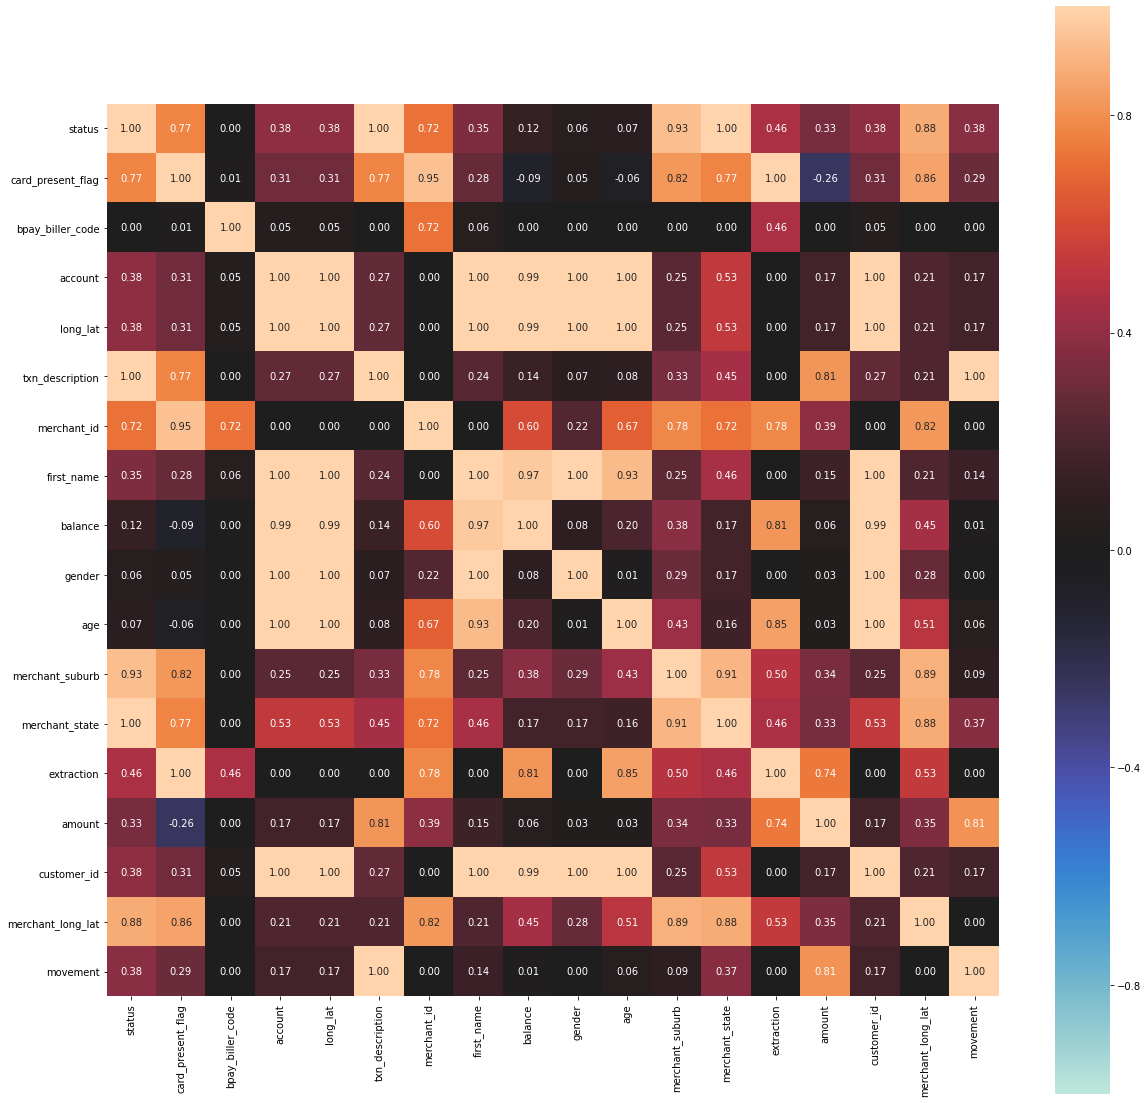

{'corr':                      status  card_present_flag  bpay_biller_code   account  \
 status             1.000000           0.770484          0.000000  0.383121   
 card_present_flag  0.770484           1.000000          0.012524  0.311925   
 bpay_biller_code   0.000000           0.012524          1.000000  0.046736   
 account            0.383121           0.311925          0.046736  1.000000   
 long_lat           0.383121           0.311925          0.046736  1.000000   
 txn_description    0.999834           0.770499          0.000000  0.266220   
 merchant_id        0.724309           0.945228          0.724340  0.000000   
 first_name         0.345659           0.281359          0.062011  0.999164   
 balance            0.120117          -0.090053          0.004681  0.993991   
 gender             0.058843           0.046738          0.000000  0.995922   
 age                0.070495          -0.058345          0.002373  1.000000   
 merchant_suburb    0.930836           0.822

In [285]:
cols = [col for col in df.columns if col not in ['date', 'merchant_code','currency','country','transaction_id']]
associations(df[cols],figsize=(20,20))

<h3>Unique values in each column</h3>

In [286]:
df.nunique()

status                   2
card_present_flag        2
bpay_biller_code         3
account                100
currency                 1
long_lat               100
txn_description          6
merchant_id           5725
merchant_code            1
first_name              80
balance              12006
date                    91
gender                   2
age                     33
merchant_suburb       1609
merchant_state           8
extraction            9442
amount                4457
transaction_id       12043
country                  1
customer_id            100
merchant_long_lat     2703
movement                 2
dtype: int64

<h3>Dropping irrelevant columns</h3>

We proceed to drop the following columns
<ul>
    <li>Currency and country only have a single value for the entire data-set</li>
    <li>Transaction_id is a unique value for each transaction/record therefore it is of no use to us</li>
    <li>merchant_code and bpay_biller_code only have NULL or 0 as their value</li>
    </ul>

In [287]:
df.drop(['currency','country','transaction_id','merchant_code','bpay_biller_code'],axis=1,inplace=True)

<h3>Calculating the annual salary of each unique customer</h3>

In [288]:
df1 = df[df['txn_description']=='PAY/SALARY']

In [289]:
df1.nunique()

status                 1
card_present_flag      0
account              100
long_lat             100
txn_description        1
merchant_id            0
first_name            80
balance              883
date                  65
gender                 2
age                   33
merchant_suburb        0
merchant_state         0
extraction           394
amount               100
customer_id          100
merchant_long_lat      0
movement               1
dtype: int64

We proceed to drop columns that are completely full of NULL values for the `txn_description` of PAY/SALARY

In [290]:
df1.dropna(axis=1,inplace=True)

The following columns are irrelevant to our predictions for annual salary
<ul>
    <li>Status, movement and txn_description have a single value for the entire set</li>
    <li>First_name only consists of 80 values while the number of customers are 100</li>
    <li>Extraction feature holds no significance towards calculating annual salary</li>
    </ul>

In [291]:
df1.drop(['status','txn_description','movement','extraction','long_lat','first_name','account'],axis=1,inplace=True)

In [292]:
df1.nunique()

balance        883
date            65
gender           2
age             33
amount         100
customer_id    100
dtype: int64

We proceed to create new columns for day and month by parsing the `date` dataset which was of datatype `datetime`

In [293]:
df1['day'] = df1['date'].dt.day
df1['month'] = df1['date'].dt.month

Grouping the dataset in terms of customer_id and month

In [294]:
df2 = df1.groupby(['customer_id','month']).amount.mean()

In [295]:
df2

customer_id     month
CUS-1005756958  8         970.47
                9         970.47
                10        970.47
CUS-1117979751  8        3578.65
                9        3578.65
                          ...   
CUS-880898248   9        1433.98
                10       1433.98
CUS-883482547   8        3977.46
                9        3977.46
                10       3977.46
Name: amount, Length: 296, dtype: float64

Calculating the mean amount (salary per month) of each customer through grouping by `customer_id` and taking the mean value of each id. We then multiply it by 12 to get the final `annual_salary` column

In [296]:
df3 = df1.groupby(['customer_id']).amount.mean()

In [297]:
df1.set_index('customer_id',inplace=True)

In [298]:
df1['annual_salary'] = df3

In [299]:
df1['annual_salary'] = df1['annual_salary']*12

In [300]:
df1.head()

,balance,date,gender,age,amount,day,month,annual_salary
customer_id,,,,,,,,
CUS-1462656821,8342.11,2018-08-01,M,23,3903.95,1,8,46847.40
CUS-2500783281,2040.58,2018-08-01,F,23,1626.48,1,8,19517.76
CUS-326006476,3158.51,2018-08-01,M,22,983.36,1,8,11800.32
CUS-1433879684,2517.66,2018-08-01,M,24,1408.08,1,8,16896.96
CUS-4123612273,2271.79,2018-08-01,F,43,1068.04,1,8,12816.48


Dropping columns which are now irrelevant to our predictions. The date of recieving salary <b>does not influence the amount that the customer earns as it is a fixed value</b>. Bank balance is also not an indicator of how much salary would a customer recieve.

In [301]:
df1.drop(['balance','date','day','month'],axis=1,inplace=True)

In [302]:
df1

,gender,age,amount,annual_salary
customer_id,,,,
CUS-1462656821,M,23,3903.95,46847.40
CUS-2500783281,F,23,1626.48,19517.76
CUS-326006476,M,22,983.36,11800.32
CUS-1433879684,M,24,1408.08,16896.96
CUS-4123612273,F,43,1068.04,12816.48
...,...,...,...,...
CUS-1646621553,M,26,1098.91,13186.92
CUS-1271030853,F,30,1158.15,13897.80
CUS-1388323263,M,69,1043.12,12517.44


In [303]:
df_i = df.set_index('customer_id')

<h3>Calculating the type and count of transactions made by each customer</h3>

We one-hot encode the `txn_description` column, group according to customer ID and sum the columns individually.

In [304]:
df_1 = pd.get_dummies(df_i['txn_description'])
df_1

,INTER BANK,PAY/SALARY,PAYMENT,PHONE BANK,POS,SALES-POS
customer_id,,,,,,
CUS-2487424745,0,0,0,0,1,0
CUS-2487424745,0,0,0,0,0,1
CUS-2142601169,0,0,0,0,1,0
CUS-1614226872,0,0,0,0,0,1
CUS-2487424745,0,0,0,0,0,1
...,...,...,...,...,...,...
CUS-55310383,0,0,0,0,1,0
CUS-2688605418,0,0,0,0,0,1
CUS-2663907001,0,0,0,0,1,0


In [305]:
df_1.reset_index(inplace=True)

In [306]:
df_final = df_1.groupby('customer_id').sum()
df_final

,INTER BANK,PAY/SALARY,PAYMENT,PHONE BANK,POS,SALES-POS
customer_id,,,,,,
CUS-1005756958,0.0,13.0,9.0,3.0,26.0,22.0
CUS-1117979751,1.0,7.0,40.0,0.0,26.0,26.0
CUS-1140341822,3.0,6.0,6.0,0.0,39.0,26.0
CUS-1147642491,2.0,13.0,27.0,0.0,38.0,38.0
CUS-1196156254,5.0,7.0,70.0,0.0,74.0,89.0
...,...,...,...,...,...,...
CUS-72755508,0.0,12.0,1.0,0.0,14.0,31.0
CUS-809013380,1.0,13.0,22.0,0.0,51.0,37.0
CUS-860700529,3.0,6.0,15.0,3.0,97.0,109.0


<b>Adding them to the present `df1` column that consists of our final features used for predictions</b>

In [307]:
df1['INTER_BANK'] = df_final['INTER BANK']
df1['PAYMENT'] = df_final['PAYMENT']
df1['PHONE BANK'] = df_final['PHONE BANK']
df1['POS'] = df_final['POS']
df1['PAY/SALARY'] = df_final['PAYMENT']
df1['SALES-POS'] = df_final['SALES-POS']

In [308]:
df1.head()

,gender,age,amount,annual_salary,INTER_BANK,PAYMENT,PHONE BANK,POS,PAY/SALARY,SALES-POS
customer_id,,,,,,,,,,
CUS-1462656821,M,23,3903.95,46847.40,17.0,28.0,0.0,35.0,28.0,29.0
CUS-2500783281,F,23,1626.48,19517.76,1.0,65.0,0.0,2.0,65.0,2.0
CUS-326006476,M,22,983.36,11800.32,0.0,6.0,3.0,15.0,6.0,9.0
CUS-1433879684,M,24,1408.08,16896.96,0.0,38.0,0.0,53.0,38.0,57.0
CUS-4123612273,F,43,1068.04,12816.48,3.0,32.0,0.0,42.0,32.0,43.0


In [309]:
df1.isnull().sum()

gender           0
age              0
amount           0
annual_salary    0
INTER_BANK       0
PAYMENT          0
PHONE BANK       0
POS              0
PAY/SALARY       0
SALES-POS        0
dtype: int64

<h3>Correlation matrix for current features</h3>

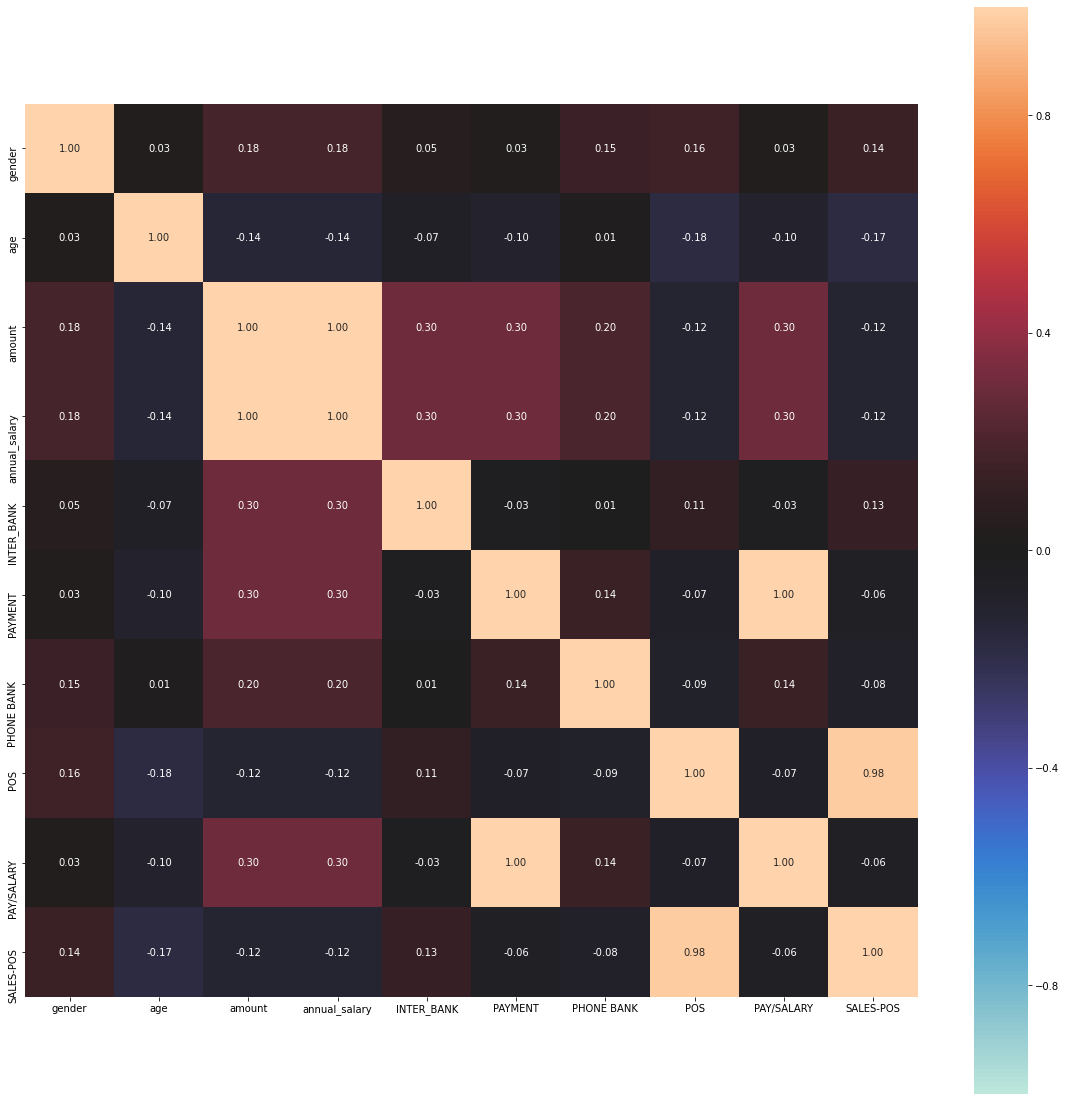

{'corr':                  gender       age    amount  annual_salary  INTER_BANK  \
 gender         1.000000  0.031567  0.181306       0.181306    0.052024   
 age            0.031567  1.000000 -0.138594      -0.138594   -0.068193   
 amount         0.181306 -0.138594  1.000000       1.000000    0.301810   
 annual_salary  0.181306 -0.138594  1.000000       1.000000    0.301810   
 INTER_BANK     0.052024 -0.068193  0.301810       0.301810    1.000000   
 PAYMENT        0.025708 -0.096824  0.301072       0.301072   -0.030630   
 PHONE BANK     0.146611  0.011260  0.195550       0.195550    0.005028   
 POS            0.163022 -0.175300 -0.122687      -0.122687    0.109187   
 PAY/SALARY     0.025708 -0.096824  0.301072       0.301072   -0.030630   
 SALES-POS      0.139096 -0.174942 -0.119339      -0.119339    0.125139   
 
                 PAYMENT  PHONE BANK       POS  PAY/SALARY  SALES-POS  
 gender         0.025708    0.146611  0.163022    0.025708   0.139096  
 age           -0.096

In [310]:
associations(df1,figsize=(20,20))

<h3>Encoding the gender column as numerical</h3>

In [311]:
df1['gender']=df1['gender'].replace({'M':0,'F':1})

In [312]:
df1.head()

,gender,age,amount,annual_salary,INTER_BANK,PAYMENT,PHONE BANK,POS,PAY/SALARY,SALES-POS
customer_id,,,,,,,,,,
CUS-1462656821,0,23,3903.95,46847.40,17.0,28.0,0.0,35.0,28.0,29.0
CUS-2500783281,1,23,1626.48,19517.76,1.0,65.0,0.0,2.0,65.0,2.0
CUS-326006476,0,22,983.36,11800.32,0.0,6.0,3.0,15.0,6.0,9.0
CUS-1433879684,0,24,1408.08,16896.96,0.0,38.0,0.0,53.0,38.0,57.0
CUS-4123612273,1,43,1068.04,12816.48,3.0,32.0,0.0,42.0,32.0,43.0


<h3>Calculating the amount of transactions done by each customer for every different txn_description</h3>

In [313]:
df[df['txn_description']=='POS'].groupby('customer_id').sum()

,card_present_flag,balance,age,amount
customer_id,,,,
CUS-1005756958,19.0,35331.60,1378,748.01
CUS-1117979751,23.0,240151.91,546,606.37
CUS-1140341822,33.0,230289.26,1092,1356.47
CUS-1147642491,24.0,337986.74,1292,2062.31
CUS-1196156254,54.0,1629736.58,2516,2305.65
...,...,...,...,...
CUS-72755508,13.0,66025.13,490,350.31
CUS-809013380,39.0,163895.68,1071,1135.01
CUS-860700529,75.0,343398.59,2910,2731.99


In [314]:
df[df['txn_description']=='SALES-POS'].groupby('customer_id').sum()

,card_present_flag,balance,age,amount
customer_id,,,,
CUS-1005756958,20.0,19208.25,1166,1062.85
CUS-1117979751,20.0,224476.91,546,3369.45
CUS-1140341822,20.0,142591.33,728,3033.07
CUS-1147642491,33.0,371992.50,1292,1823.44
CUS-1196156254,74.0,1952620.40,3026,2634.96
...,...,...,...,...
CUS-72755508,26.0,134901.13,1085,1204.22
CUS-809013380,31.0,121777.51,777,1267.17
CUS-860700529,88.0,369634.65,3270,3251.17


In [315]:
df[df['txn_description']=='PHONE BANK'].groupby('customer_id').sum()

,card_present_flag,balance,age,amount
customer_id,,,,
CUS-1005756958,0.0,13952.44,159,546.0
CUS-1646183815,0.0,164206.34,234,450.0
CUS-1896554896,0.0,9869.28,35,1916.0
CUS-2155701614,0.0,32964.72,105,246.0
CUS-2348881191,0.0,1220.75,41,1629.0
CUS-2376382098,0.0,47474.18,117,531.0
CUS-261674136,0.0,183490.24,377,559.0
CUS-3151318058,0.0,540292.84,588,504.0
CUS-3180318393,0.0,92979.49,351,871.0


In [316]:
df[df['txn_description']=='INTER BANK'].groupby('customer_id').sum()

,card_present_flag,balance,age,amount
customer_id,,,,
CUS-1117979751,0.0,7282.51,21,1001.0
CUS-1140341822,0.0,16483.96,84,270.0
CUS-1147642491,0.0,15550.20,68,250.0
CUS-1196156254,0.0,111327.90,170,767.0
CUS-1271030853,0.0,68670.57,480,1219.0
...,...,...,...,...
CUS-51506836,0.0,240011.26,360,3794.0
CUS-527400765,0.0,2958417.28,600,917.0
CUS-55310383,0.0,24789.19,90,465.0


<h3>Adding them to the final dataset</h3>

In [317]:
df1['POS_Amount'] = df[df['txn_description']=='POS'].groupby('customer_id').sum().amount

In [318]:
df1['SALES-POS_Amount'] = df[df['txn_description']=='SALES-POS'].groupby('customer_id').sum().amount

In [319]:
df1['PHONE BANK Amount'] = df[df['txn_description']=='PHONE BANK'].groupby('customer_id').sum().amount

In [320]:
df1['INTER_BANK_AMOUNT'] = df[df['txn_description']=='INTER BANK'].groupby('customer_id').sum().amount

In [321]:
df1.head()

,gender,age,amount,annual_salary,INTER_BANK,PAYMENT,PHONE BANK,POS,PAY/SALARY,SALES-POS,POS_Amount,SALES-POS_Amount,PHONE BANK Amount,INTER_BANK_AMOUNT
customer_id,,,,,,,,,,,,,,
CUS-1462656821,0,23,3903.95,46847.40,17.0,28.0,0.0,35.0,28.0,29.0,1787.65,1427.90,NaN,701.0
CUS-2500783281,1,23,1626.48,19517.76,1.0,65.0,0.0,2.0,65.0,2.0,31.26,19.24,NaN,213.0
CUS-326006476,0,22,983.36,11800.32,0.0,6.0,3.0,15.0,6.0,9.0,604.72,356.21,474.0,NaN
CUS-1433879684,0,24,1408.08,16896.96,0.0,38.0,0.0,53.0,38.0,57.0,2251.27,1741.53,NaN,NaN
CUS-4123612273,1,43,1068.04,12816.48,3.0,32.0,0.0,42.0,32.0,43.0,2815.62,2124.94,NaN,591.0


In [322]:
df1.isnull().sum()

gender                 0
age                    0
amount                 0
annual_salary          0
INTER_BANK             0
PAYMENT                0
PHONE BANK             0
POS                    0
PAY/SALARY             0
SALES-POS              0
POS_Amount             0
SALES-POS_Amount      12
PHONE BANK Amount    746
INTER_BANK_AMOUNT    285
dtype: int64

<b>Filling NULL values with 0 as they the users haven't made any transactions with regards to that description.</b>

In [323]:
df1.fillna(0,inplace=True)

In [324]:
df1.isnull().sum()

gender               0
age                  0
amount               0
annual_salary        0
INTER_BANK           0
PAYMENT              0
PHONE BANK           0
POS                  0
PAY/SALARY           0
SALES-POS            0
POS_Amount           0
SALES-POS_Amount     0
PHONE BANK Amount    0
INTER_BANK_AMOUNT    0
dtype: int64

<h3>Correlation matrix of current features</h3>

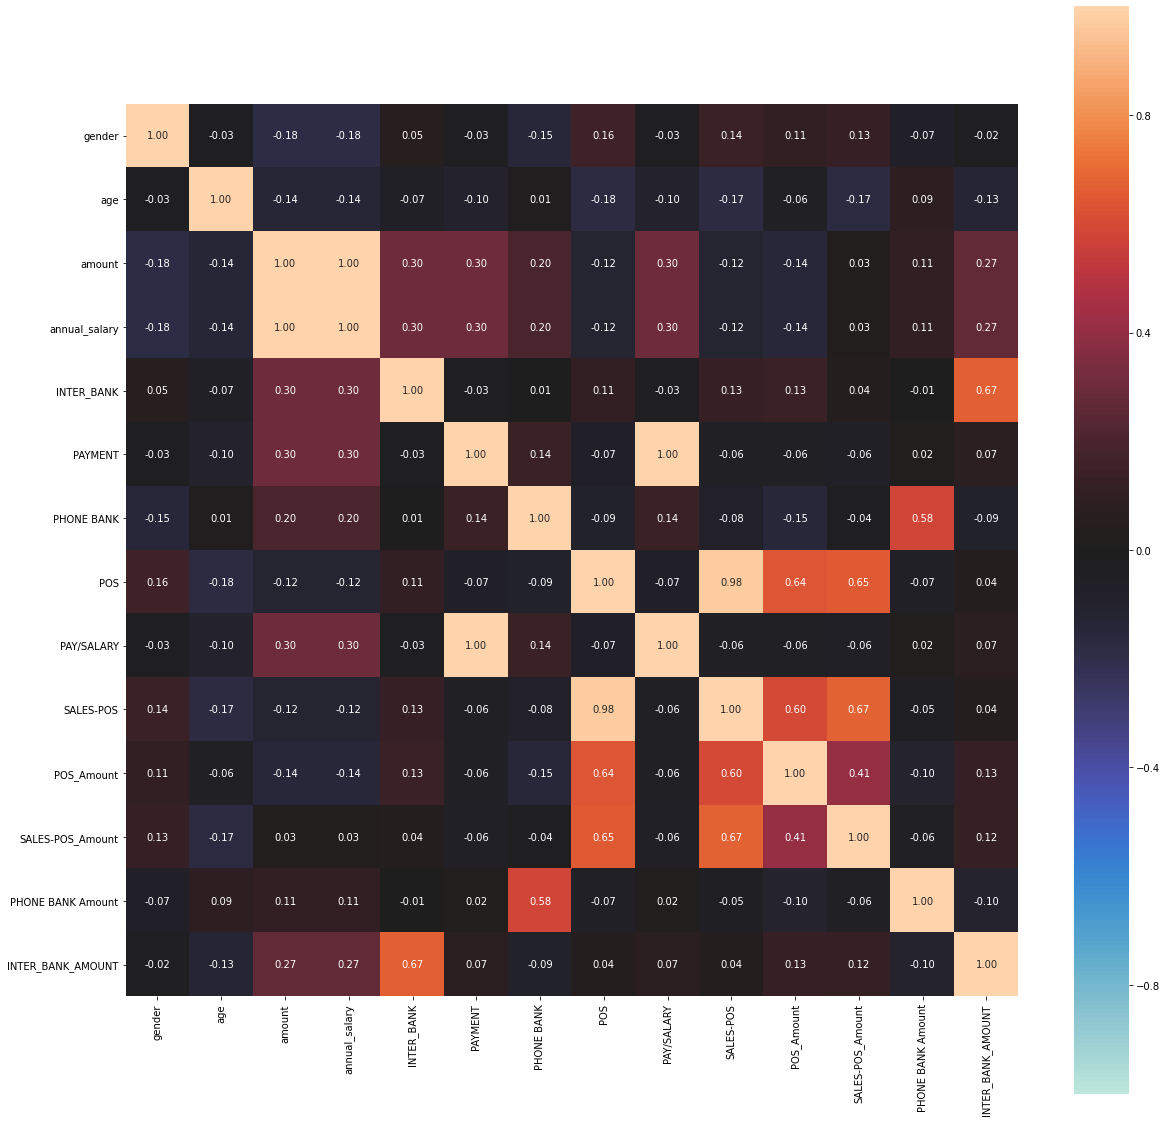

{'corr':                      gender       age    amount  annual_salary  INTER_BANK  \
 gender             1.000000 -0.031567 -0.181306      -0.181306    0.052024   
 age               -0.031567  1.000000 -0.138594      -0.138594   -0.068193   
 amount            -0.181306 -0.138594  1.000000       1.000000    0.301810   
 annual_salary     -0.181306 -0.138594  1.000000       1.000000    0.301810   
 INTER_BANK         0.052024 -0.068193  0.301810       0.301810    1.000000   
 PAYMENT           -0.025708 -0.096824  0.301072       0.301072   -0.030630   
 PHONE BANK        -0.146611  0.011260  0.195550       0.195550    0.005028   
 POS                0.163022 -0.175300 -0.122687      -0.122687    0.109187   
 PAY/SALARY        -0.025708 -0.096824  0.301072       0.301072   -0.030630   
 SALES-POS          0.139096 -0.174942 -0.119339      -0.119339    0.125139   
 POS_Amount         0.105581 -0.060089 -0.143877      -0.143877    0.134509   
 SALES-POS_Amount   0.128785 -0.166394  0.03

In [325]:
associations(df1,figsize=(20,20))

<h3>Cleaning the amount value skewness</h3>

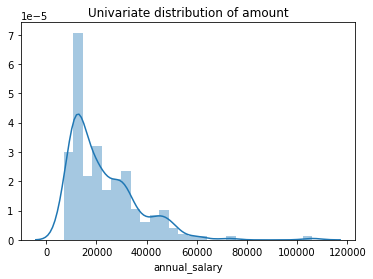

In [326]:
sns.distplot(df1['annual_salary'])
plt.title('Univariate distribution of amount')
plt.show()

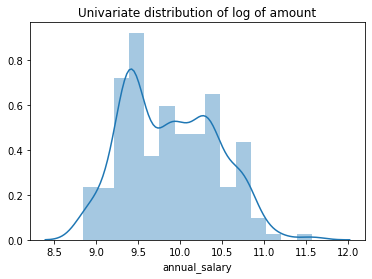

In [327]:
sns.distplot(np.log(df1['annual_salary']))
plt.title('Univariate distribution of log of amount')
plt.show()

<h3>Adding the log amount value and removing the older one</h3>

In [328]:
df1['log_annual_salary'] = np.log(df1['annual_salary'])

In [329]:
df1.drop('amount',axis=1,inplace=True)

In [330]:
df1.shape

(883, 14)

In [331]:
df1.reset_index(inplace=True)
df1.drop('customer_id',axis=1,inplace=True)

<h2>Predictive modeling</h2>

<h3>Train-test data-sets for model</h3>

In [371]:
X = df1.drop(['annual_salary','log_annual_salary'],axis=1)
y = df1['annual_salary']

In [372]:
X.head()

,gender,age,INTER_BANK,PAYMENT,PHONE BANK,POS,PAY/SALARY,SALES-POS,POS_Amount,SALES-POS_Amount,PHONE BANK Amount,INTER_BANK_AMOUNT
0,0,23,17.0,28.0,0.0,35.0,28.0,29.0,1787.65,1427.90,0.0,701.0
1,1,23,1.0,65.0,0.0,2.0,65.0,2.0,31.26,19.24,0.0,213.0
2,0,22,0.0,6.0,3.0,15.0,6.0,9.0,604.72,356.21,474.0,0.0
3,0,24,0.0,38.0,0.0,53.0,38.0,57.0,2251.27,1741.53,0.0,0.0
4,1,43,3.0,32.0,0.0,42.0,32.0,43.0,2815.62,2124.94,0.0,591.0


In [373]:
y = np.log(y)
y

0      10.754651
1       9.879080
2       9.375882
3       9.734889
4       9.458487
         ...    
878     9.486981
879     9.539486
880     9.434878
881     9.725908
882    10.363350
Name: annual_salary, Length: 883, dtype: float64

Here, we used `test_size` as 0.15. Our dataset is quite small as we need enough data for the model to train on, <b>therefore we used an 85-15 train-test split</b>

In [374]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

In [375]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(750, 12)
(133, 12)
(750,)
(133,)


In [376]:
X.columns

Index(['gender', 'age', 'INTER_BANK', 'PAYMENT', 'PHONE BANK', 'POS',
       'PAY/SALARY', 'SALES-POS', 'POS_Amount', 'SALES-POS_Amount',
       'PHONE BANK Amount', 'INTER_BANK_AMOUNT'],
      dtype='object')

<h3>Scaling the data with sparse ranges</h3>

We scale the data to get a more robust normalized model which performs more accurate predictions and runs more efficiently.

In [377]:
cols_to_scale = ['POS_Amount','SALES-POS_Amount','PHONE BANK Amount','INTER_BANK_AMOUNT']

s = MinMaxScaler()
X_train[cols_to_scale] = s.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = s.transform(X_test[cols_to_scale])

In [378]:
X_train

,gender,age,INTER_BANK,PAYMENT,PHONE BANK,POS,PAY/SALARY,SALES-POS,POS_Amount,SALES-POS_Amount,PHONE BANK Amount,INTER_BANK_AMOUNT
543,1,20,20.0,31.0,0.0,55.0,31.0,46.0,0.196053,0.474465,0.000000,0.306800
623,1,20,19.0,13.0,0.0,71.0,13.0,83.0,0.204409,0.498509,0.000000,0.416183
177,0,40,23.0,37.0,0.0,12.0,37.0,29.0,0.063328,0.152673,0.000000,0.304428
599,1,23,1.0,65.0,0.0,2.0,65.0,2.0,0.001398,0.003335,0.000000,0.056141
589,1,18,3.0,14.0,0.0,39.0,14.0,29.0,0.122576,0.094808,0.000000,0.121771
...,...,...,...,...,...,...,...,...,...,...,...,...
804,1,23,1.0,65.0,0.0,2.0,65.0,2.0,0.001398,0.003335,0.000000,0.056141
135,0,22,0.0,6.0,3.0,15.0,6.0,9.0,0.071126,0.061751,0.247390,0.000000
127,1,53,0.0,9.0,3.0,26.0,9.0,22.0,0.088548,0.184250,0.284969,0.000000
175,1,24,16.0,30.0,0.0,95.0,30.0,106.0,0.443570,0.461508,0.000000,0.176595


In [379]:
X_test.head()

,gender,age,INTER_BANK,PAYMENT,PHONE BANK,POS,PAY/SALARY,SALES-POS,POS_Amount,SALES-POS_Amount,PHONE BANK Amount,INTER_BANK_AMOUNT
53,0,28,0.0,35.0,12.0,50.0,35.0,65.0,0.270024,0.627937,0.363257,0.000000
339,1,19,12.0,15.0,0.0,9.0,15.0,9.0,0.050609,0.053853,0.000000,0.069584
251,0,42,3.0,17.0,0.0,5.0,17.0,9.0,0.023083,0.111909,0.000000,0.125725
480,0,42,13.0,12.0,0.0,27.0,12.0,22.0,0.184691,0.192257,0.000000,0.068529
224,1,24,3.0,27.0,0.0,28.0,27.0,17.0,0.083608,0.081314,0.000000,0.146284


In [380]:
y_train.head()

543     9.725908
623     9.522628
177    10.216995
599     9.879080
589     9.119974
Name: annual_salary, dtype: float64

<h2>Scatter plots and predictions with one feature at a time</h2>

<h3>Age vs Amount predictions</h3>

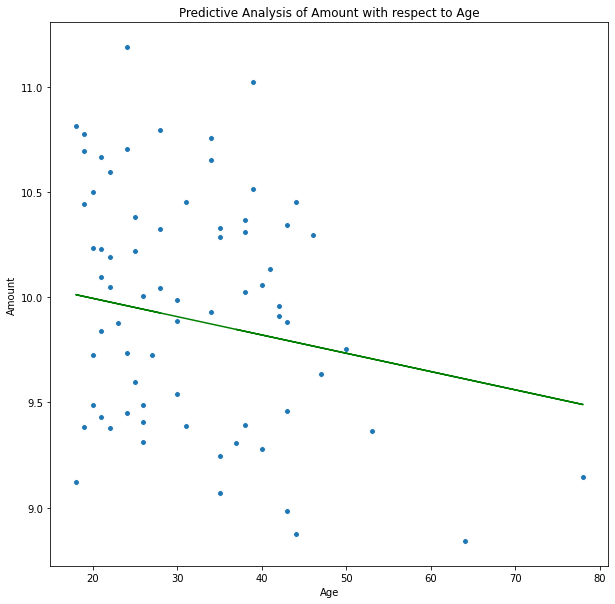

In [381]:
clf = LinearRegression()
clf.fit(np.array(X_train['age']).reshape(-1,1),y_train)
y_pred = clf.predict(np.array(X_test['age']).reshape(-1,1))
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Age')
ax.set_ylabel('Amount')
ax.set_title('Predictive Analysis of Amount with respect to Age')
ax.scatter(X_test['age'],y_test,edgecolor='w')
ax.plot(X_test['age'], y_pred, color='green',linewidth=1.5)
plt.show()

<h3>Amount vs POS Amount Scaled</h3>

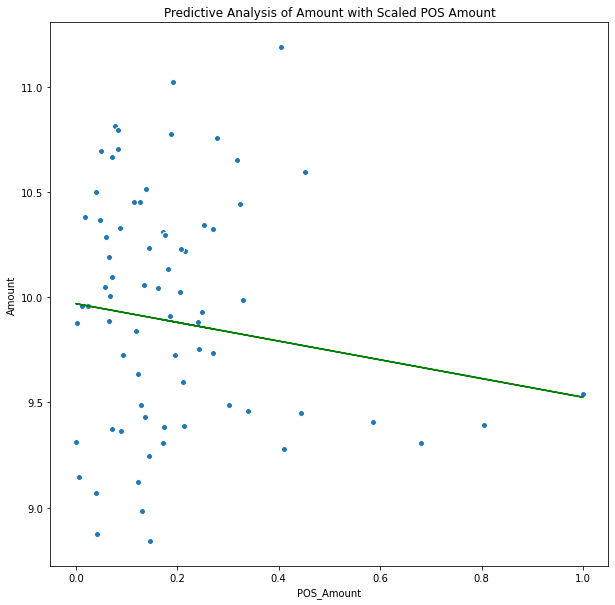

In [382]:
clf = LinearRegression()
clf.fit(np.array(X_train['POS_Amount']).reshape(-1,1),y_train)
y_pred = clf.predict(np.array(X_test['POS_Amount']).reshape(-1,1))
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('POS_Amount')
ax.set_ylabel('Amount')
ax.set_title('Predictive Analysis of Amount with Scaled POS Amount')
ax.scatter(X_test['POS_Amount'],y_test,edgecolor='w')
ax.plot(X_test['POS_Amount'], y_pred, color='green',linewidth=1.5)
plt.show()

<h3>Amount vs SALES-POS Amount Scaled</h3>

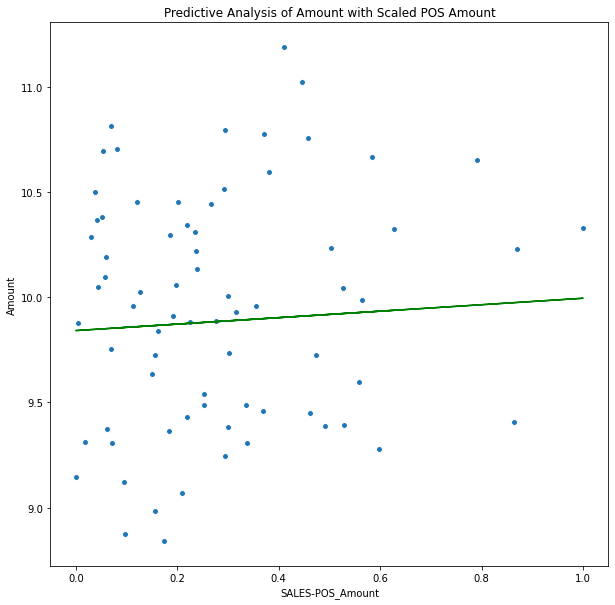

In [383]:
clf = LinearRegression()
clf.fit(np.array(X_train['SALES-POS_Amount']).reshape(-1,1),y_train)
y_pred = clf.predict(np.array(X_test['SALES-POS_Amount']).reshape(-1,1))
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('SALES-POS_Amount')
ax.set_ylabel('Amount')
ax.set_title('Predictive Analysis of Amount with Scaled POS Amount')
ax.scatter(X_test['SALES-POS_Amount'],y_test,edgecolor='w')
ax.plot(X_test['SALES-POS_Amount'], y_pred, color='green',linewidth=1.5)
plt.show()

<h3>Amount vs PHONE BANK Amount Scaled</h3>

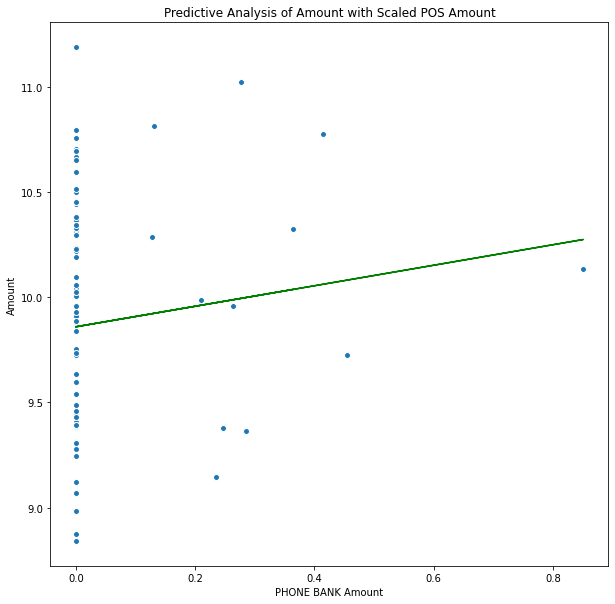

In [384]:
clf = LinearRegression()
clf.fit(np.array(X_train['PHONE BANK Amount']).reshape(-1,1),y_train)
y_pred = clf.predict(np.array(X_test['PHONE BANK Amount']).reshape(-1,1))
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('PHONE BANK Amount')
ax.set_ylabel('Amount')
ax.set_title('Predictive Analysis of Amount with Scaled POS Amount')
ax.scatter(X_test['PHONE BANK Amount'],y_test,edgecolor='w')
ax.plot(X_test['PHONE BANK Amount'], y_pred, color='green',linewidth=1.5)
plt.show()

<h3>Amount Vs Sales-POS</h3>

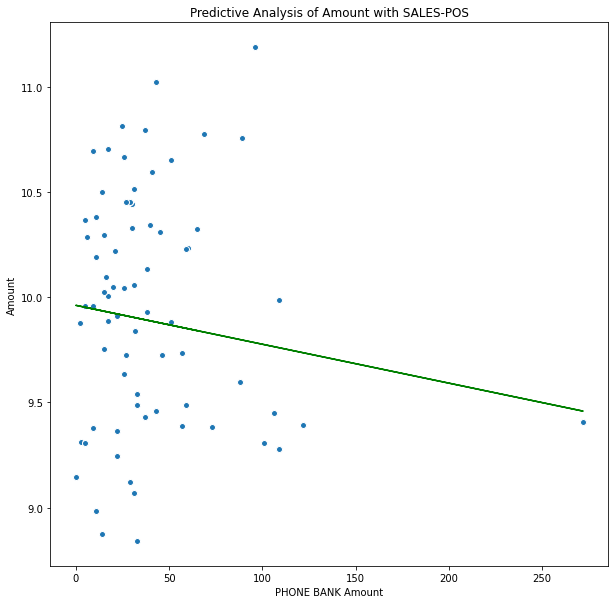

In [385]:
clf = LinearRegression()
clf.fit(np.array(X_train['SALES-POS']).reshape(-1,1),y_train)
y_pred = clf.predict(np.array(X_test['SALES-POS']).reshape(-1,1))
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('PHONE BANK Amount')
ax.set_ylabel('Amount')
ax.set_title('Predictive Analysis of Amount with SALES-POS')
ax.scatter(X_test['SALES-POS'],y_test,edgecolor='w')
ax.plot(X_test['SALES-POS'], y_pred, color='green',linewidth=1.5)
plt.show()

<h2>Feature Importances</h2>

We use popular regressors to return feature importances in the dataset. This can be used for further analysis and studies. It is a means to define the features that are the most impactful and critical to our target variable, which here is the `annual_salary`.

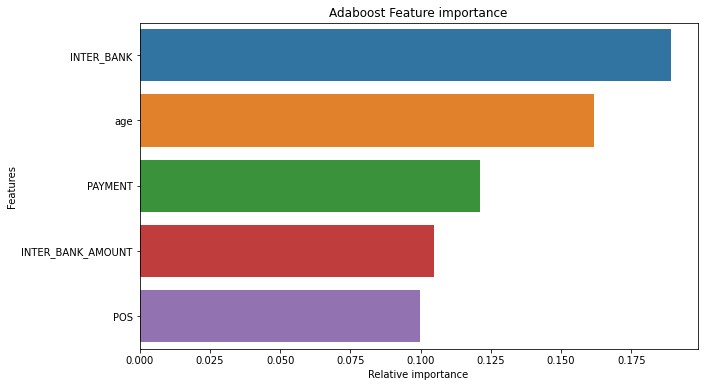

In [386]:
ada = AdaBoostRegressor()
ada.fit(X_train,y_train)
l1 = np.argsort(ada.feature_importances_)[::-1][:5]
plt.figure(figsize=(10,6))
g1 = sns.barplot(y=X_train.columns[l1][:5],x=ada.feature_importances_[l1][:5],orient='h')
g1.set_xlabel('Relative importance')
g1.set_ylabel('Features')
g1.set_title('Adaboost Feature importance')
plt.show()

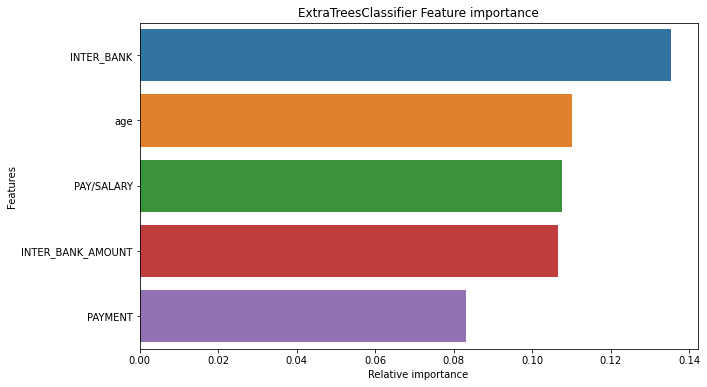

In [387]:
etc = ExtraTreesRegressor()
etc.fit(X_train,y_train)
e1 = np.argsort(etc.feature_importances_)[::-1][:5]
plt.figure(figsize=(10,6))
g2 = sns.barplot(y=X_train.columns[e1][:5],x=etc.feature_importances_[e1][:5],orient='h')
g2.set_xlabel('Relative importance')
g2.set_ylabel('Features')
g2.set_title('ExtraTreesClassifier Feature importance')
plt.show()

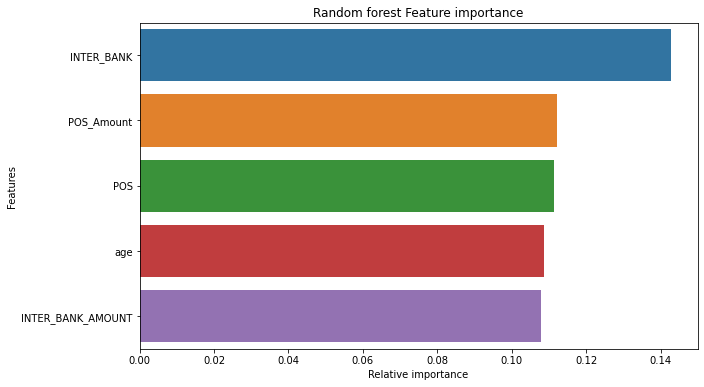

In [388]:
rf_b = RandomForestRegressor()
rf_b.fit(X_train,y_train)
f1 = np.argsort(rf_b.feature_importances_)[::-1][:5]
plt.figure(figsize=(10,6))
g3 = sns.barplot(y=X_train.columns[f1][:5],x=rf_b.feature_importances_[f1][:5],orient='h')
g3.set_xlabel('Relative importance')
g3.set_ylabel('Features')
g3.set_title('Random forest Feature importance')
plt.show()

<h3>Predictive analysis through a slew of basic regressor classifiers</h3>

In [389]:
random_state = 0
models = []
models.append(LinearRegression())
models.append(DecisionTreeRegressor(random_state=random_state))
models.append(AdaBoostRegressor(random_state=random_state))
models.append(RandomForestRegressor(random_state=random_state))
models.append(ExtraTreesRegressor(random_state=random_state))
models.append(GradientBoostingRegressor(random_state=random_state))
models.append(MLPRegressor(random_state=random_state))
models.append(KNeighborsRegressor())
models.append(XGBRegressor(random_state=random_state))

In [390]:
error = []
for regressor in models:
    regressor.fit(X_train,y_train)
    y_pred = regressor.predict(X_test)
    acc = mean_squared_error(y_test,y_pred)
    error.append(acc)

#['Linear Regression','Decision Tree','AdaBoost','RandomForest','Extra Trees','Gradient Boosting', 'Multi-layer-perceptron','K-NearestNeighbors','XBGRegressor']

[12:01:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<h3>MSE (mean squared error) values aquired after predictions</h3>

We see that almost all of our predictions have very less MSE, the model has proven to be very effective.

In [391]:
d1 = {'Linear Regression':error[0],'Decision Tree Regression':error[1],'AdaBoosting Regression':error[2],'Random Forest Regression':error[3],'Extra Trees Regressor':error[4],'Gradient Boosting Regressor':error[5],'MLP Regressor':error[6],'KNeighbors Regressor':error[7],'XGB Regressor':error[8]}
d1

{'Linear Regression': 0.17803211283669618,
 'Decision Tree Regression': 5.627088792119358e-13,
 'AdaBoosting Regression': 0.11156212947908717,
 'Random Forest Regression': 0.0006659648141488445,
 'Extra Trees Regressor': 6.066016153333994e-12,
 'Gradient Boosting Regressor': 0.008867025126664199,
 'MLP Regressor': 0.9812089344944819,
 'KNeighbors Regressor': 0.030400382875698975,
 'XGB Regressor': 0.017031243956283384}

<h3>Decision Tree Regression</h3>

We run the Decision Tree regressor first without any form of parameter tuning. We use the default values and get the mean squared error of about <b>1.44</b>

In [392]:
clf = DecisionTreeRegressor(random_state=random_state)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
err = mean_squared_error(y_test,y_pred)
err

5.627088792119358e-13

<h3>The model is overfitting, the error is too less and the accuracy of 1 cross-verifies it</h3>

In [393]:
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 1.00 (+/- 0.00)


<h3>HyperParameter Tuning</h3>

We use `GridSearchCV` for parameter tuning. This will reduce the accuracy but also make the model generalize better

In [400]:
param_grid = {
    'criterion':['mse','mae','friedman_mse'],
    'splitter':['best','random'],
    'max_depth':[2,3,4,5,6,7,8,9,10,11,12],
    'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,15],
    'max_features':[1,2,3,4,5,6,7,8,9,10,11,12],
    'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10]
}

clf_cv = GridSearchCV(clf,param_grid=param_grid,scoring='neg_mean_squared_error',n_jobs=4,verbose=1)

In [401]:
clf_cv.fit(X_train,y_train)

Fitting 3 folds for each of 102960 candidates, totalling 308880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 362 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 22862 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 60362 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done 111737 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 142941 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 163291 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 187341 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 215091 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 276733 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done 308880 out of 308880 | elapsed:  7.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=0,
                                             splitter='best'),
             iid='warn', n_jobs=4,
             param_grid...riterion': ['mse', 'mae', 'friedman_mse'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9,

<h3>Best parameters according to the Grid Search</h3>

In [407]:
print(clf_cv.best_params_)

{'criterion': 'friedman_mse', 'max_depth': 12, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 9, 'splitter': 'best'}


<h3>Best NSME score</h3>

In [408]:
print(clf_cv.best_score_)

-0.004922411075406666


<h3>The new mean squared error value on the finely tuned model</h3>

In [409]:
y_pred = clf_cv.predict(X_test)
err_cv = mean_squared_error(y_test,y_pred)
err_cv

0.002217457691714807

<h2>Conclusion</h2>

Through this whole process, we were successful in identifying the key features for our target variable `amount` and their levels of importance. 

We were able to extract key features already present in the dataset such as `age` and `gender`

New features such as `POS`, `POS-Amount`, `PHONE BANK` etc. were extracted from the present dataset which aided as additional features for our machine learning model.

The models were carefully scaled and the features were selected in a manner to prevent any form of <b>data leakage</b>. All the features used for modeling can be obtained before predictions in real-world instances as well

We were successfull in creating a linear regression model with more than 99% accuracy. Some predictions based off only a single variable were also done and mapped out <b>to identify correlations between the features and the target variable</b>

We created a decision tree regressor and tuned its hyperparameters to achieve less than 0.01% MSE (mean squared error)

<h3>Can this model be used to segment customers into income brackets for reporting purposes??</h3>

As the model achieved very good accuracy with very low scores (below 0.01% MSE), we can use this as a baseline process of segmenting customers into income brackets through accumulating the respective features and predicting the annual salary.

<h3>Note: The model does predict logarithmic values of annual salary, we can take the anti-log for the final results</h3>

The model can be further enhanced through the addition of more data and also creating voting regressors that merge the results of many different classifiers to achieve even higher performance. We can also employ neural networks to perform this procedure to further improve our results. This can help mitigate unforseen circumstances as well as provide key-insights for <b>further studies such as employee performance, company growth margins, weak sectors etc.</b>
